In [1]:
!gdown 1p2IO2aBvcQYtdRdHx3QPxhhO3Dl84kdL
!gdown 1xYboSfoDp3wkdHop0acCreWom1uBBHPY

Downloading...
From: https://drive.google.com/uc?id=1p2IO2aBvcQYtdRdHx3QPxhhO3Dl84kdL
To: /content/sudoku_raw.png
100% 16.7k/16.7k [00:00<00:00, 21.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xYboSfoDp3wkdHop0acCreWom1uBBHPY
To: /content/normalblank.jpg
100% 132k/132k [00:00<00:00, 65.9MB/s]


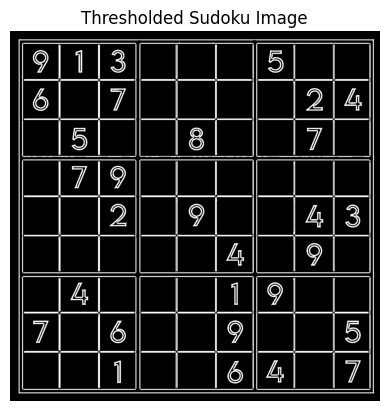

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('/content/normalblank.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur + Adaptive Thresholding
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Show thresholded image
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Sudoku Image")
plt.axis('off')
plt.show()


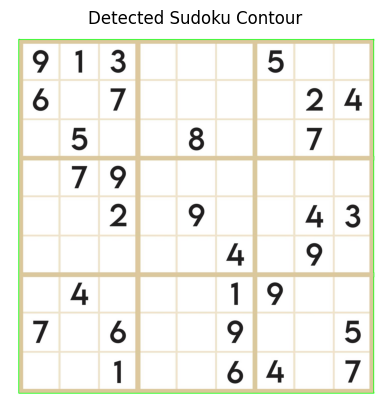

In [3]:
# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find largest contour (assumed to be the grid)
largest_area = 0
sudoku_contour = None
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > largest_area:
        largest_area = area
        sudoku_contour = cnt

# Draw it on a copy of the original
sudoku_outline = image.copy()
cv2.drawContours(sudoku_outline, [sudoku_contour], -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(sudoku_outline, cv2.COLOR_BGR2RGB))
plt.title("Detected Sudoku Contour")
plt.axis('off')
plt.show()


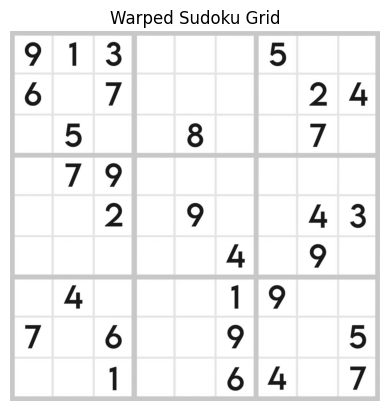

In [4]:
def reorder_points(pts):
    pts = pts.reshape((4, 2))
    new_pts = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    new_pts[0] = pts[np.argmin(s)]      # top-left
    new_pts[2] = pts[np.argmax(s)]      # bottom-right
    new_pts[1] = pts[np.argmin(diff)]   # top-right
    new_pts[3] = pts[np.argmax(diff)]   # bottom-left

    return new_pts

# Approximate the polygon
peri = cv2.arcLength(sudoku_contour, True)
approx = cv2.approxPolyDP(sudoku_contour, 0.02 * peri, True)

if len(approx) == 4:
    pts = reorder_points(approx)
    side = max([
        np.linalg.norm(pts[0] - pts[1]),
        np.linalg.norm(pts[1] - pts[2]),
        np.linalg.norm(pts[2] - pts[3]),
        np.linalg.norm(pts[3] - pts[0])
    ])
    dst_pts = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(pts, dst_pts)
    warped = cv2.warpPerspective(gray, M, (int(side), int(side)))

    plt.imshow(warped, cmap='gray')
    plt.title("Warped Sudoku Grid")
    plt.axis('off')
    plt.show()
else:
    print("Could not detect 4-cornered contour!")


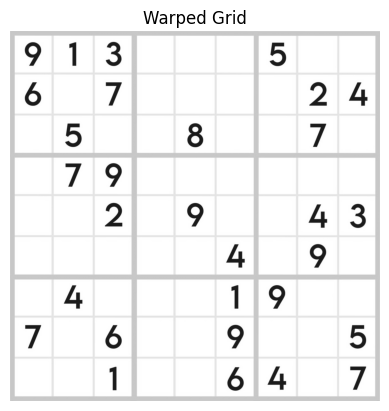

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load warped grid

cv2.imwrite("warped_grid.jpg", warped)
warped = cv2.imread('/content/warped_grid.jpg', cv2.IMREAD_GRAYSCALE)
assert warped is not None, "warped_grid.jpg not found!"

plt.imshow(warped, cmap='gray')
plt.title("Warped Grid")
plt.axis('off')
plt.show()

side = warped.shape[0]  # assuming square
cell_size = side // 9


In [6]:
cells = []

for row in range(9):
    for col in range(9):
        x_start = col * cell_size
        y_start = row * cell_size
        cell = warped[y_start:y_start+cell_size, x_start:x_start+cell_size]
        cells.append(cell)


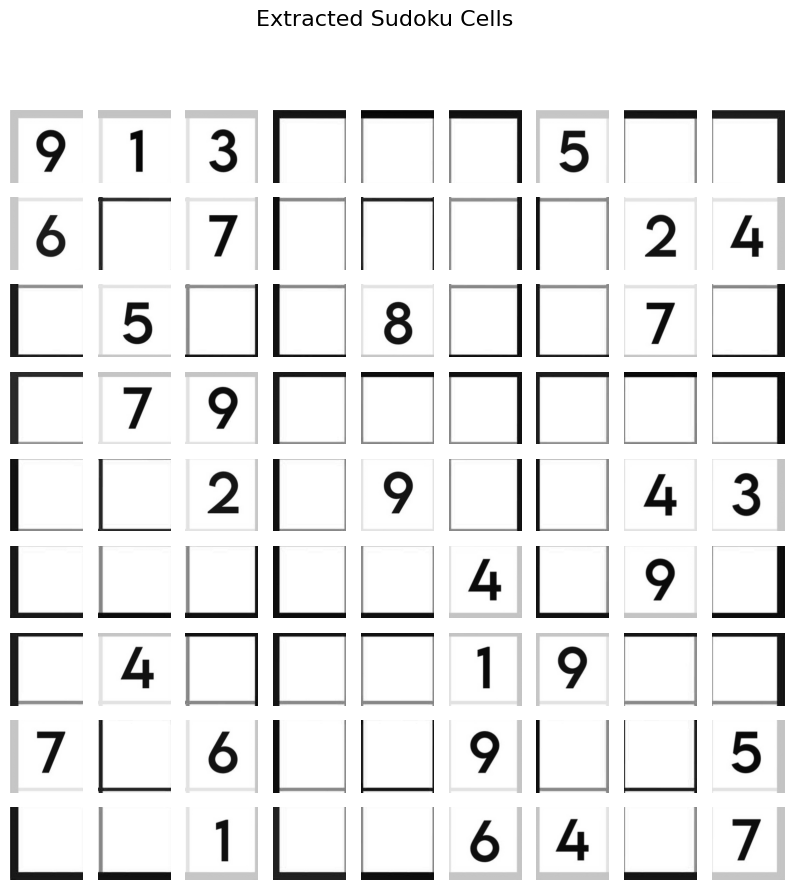

In [7]:
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

for i in range(9):
    for j in range(9):
        axs[i, j].imshow(cells[i * 9 + j], cmap='gray')
        axs[i, j].axis('off')

plt.suptitle("Extracted Sudoku Cells", fontsize=16)
plt.show()


In [8]:
import os

os.makedirs('cells/', exist_ok=True)

for i, cell in enumerate(cells):
    filename = f'cells/cell_{i}.png'
    cv2.imwrite(filename, cell)


In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to 0–1 range
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.8715 - loss: 0.4231 - val_accuracy: 0.9850 - val_loss: 0.0530
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.9830 - loss: 0.0541 - val_accuracy: 0.9883 - val_loss: 0.0377
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9890 - loss: 0.0336 - val_accuracy: 0.9880 - val_loss: 0.0385
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9918 - loss: 0.0263 - val_accuracy: 0.9888 - val_loss: 0.0398
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.9932 - loss: 0.0221 - val_accuracy: 0.9903 - val_loss: 0.0371


In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9859 - loss: 0.0399
Test Accuracy: 0.9894


In [14]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/sudoku_model.keras')   # Preferred way


Mounted at /content/drive


In [15]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/sudoku_model.keras')  # or .h5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
import cv2
import numpy as np
import os

cells = []

for i in range(81):
    path = f'/content/cells/cell_{i}.png'  # adjust path if needed
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    cells.append(img)


In [17]:
def preprocess_cell(cell):
    # Crop borders
    cell = cell[5:-5, 5:-5]

    # Resize to 28x28
    cell = cv2.resize(cell, (28, 28))

    # Normalize pixel values
    cell = cell.astype('float32') / 255.0

    # Reshape to match CNN input shape
    return cell.reshape(1, 28, 28, 1)

def is_empty(cell, threshold=0.98):
    return np.sum(cell > 200) / cell.size > threshold


In [32]:
sudoku_grid = np.zeros((9, 9), dtype=int)

for i, cell in enumerate(cells):
    if is_empty(cell):
        continue

    input_img = preprocess_cell(cell)
    prediction = model.predict(input_img)
    confidence = np.max(prediction)
    predicted_digit = np.argmax(prediction)

    row = i // 9
    col = i % 9

    if confidence > 0.85:
        sudoku_grid[row][col] = predicted_digit
    else:
        sudoku_grid[row][col] = 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

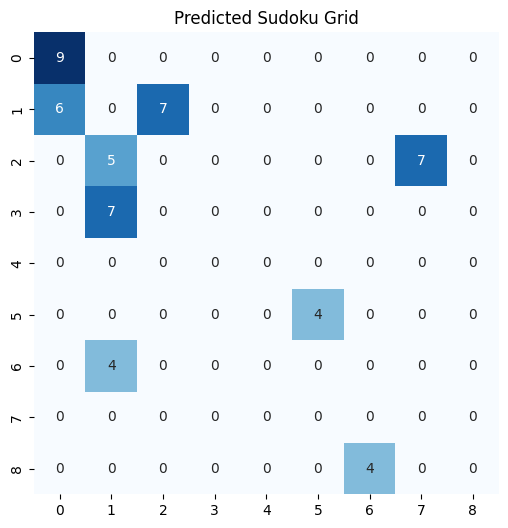

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(sudoku_grid, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Predicted Sudoku Grid")
plt.show()


In [35]:
def is_valid(grid, row, col, num):
    # Check row
    if num in grid[row]:
        return False

    # Check column
    if num in grid[:, col]:
        return False

    # Check 3x3 box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3
    if num in grid[box_row:box_row+3, box_col:box_col+3]:
        return False

    return True


In [36]:
def solve_sudoku(grid):
    for row in range(9):
        for col in range(9):
            if grid[row][col] == 0:
                for num in range(1, 10):
                    if is_valid(grid, row, col, num):
                        grid[row][col] = num
                        if solve_sudoku(grid):
                            return True
                        grid[row][col] = 0  # Backtrack
                return False
    return True


Sudoku Solved!


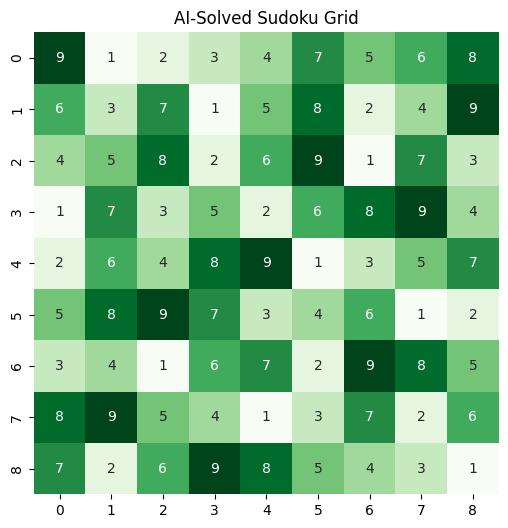

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy to avoid modifying original
solved_grid = sudoku_grid.copy()

if solve_sudoku(solved_grid):
    print("Sudoku Solved!")
    plt.figure(figsize=(6, 6))
    sns.heatmap(solved_grid, annot=True, fmt='d', cmap="Greens", cbar=False)
    plt.title("AI-Solved Sudoku Grid")
    plt.show()
else:
    print("Could not solve the puzzle.")


In [39]:
print("Predicted Grid (before solving):")
print(sudoku_grid)


Predicted Grid (before solving):
[[9 0 0 0 0 0 0 0 0]
 [6 0 7 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 7 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0]
 [0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0]]


In [40]:
def is_grid_valid(grid):
    for row in range(9):
        for col in range(9):
            num = grid[row][col]
            if num != 0:
                grid[row][col] = 0  # Temporarily remove it
                if not is_valid(grid, row, col, num):
                    print(f"Conflict at ({row},{col}) with number {num}")
                    return False
                grid[row][col] = num
    return True


In [41]:
if is_grid_valid(sudoku_grid):
    print("Grid is valid. Solving...")
    if solve_sudoku(sudoku_grid):
        print("Solved successfully!")
    else:
        print("Solver failed even though grid is valid.")
else:
    print("Grid has conflicts. Fix prediction or filter better.")


Grid is valid. Solving...
Solved successfully!


In [42]:
pip install gradio --quiet


In [56]:
#Import Packages
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model

#Load Your Trained Digit Recognition Model
model = load_model('/content/drive/MyDrive/sudoku_model.keras')  # Update path if needed


#Draw Clean Sudoku Grid
def draw_grid(grid, output_path="output.png"):
    img_size = 450
    cell_size = img_size // 9
    img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # White canvas

    for i in range(9):
        for j in range(9):
            num = grid[i][j]
            if num != 0:
                text = str(num)
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 1.2
                thickness = 2
                text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                text_x = j * cell_size + (cell_size - text_size[0]) // 2
                text_y = i * cell_size + (cell_size + text_size[1]) // 2
                cv2.putText(img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness)

    for i in range(10):
        line_thickness = 3 if i % 3 == 0 else 1
        cv2.line(img, (0, i * cell_size), (img_size, i * cell_size), (180, 150, 110), line_thickness)
        cv2.line(img, (i * cell_size, 0), (i * cell_size, img_size), (180, 150, 110), line_thickness)

    cv2.imwrite(output_path, img)
    return output_path


#Main Sudoku Processor
def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sudoku_contour = max(contours, key=cv2.contourArea)
    peri = cv2.arcLength(sudoku_contour, True)
    approx = cv2.approxPolyDP(sudoku_contour, 0.02 * peri, True)

    if len(approx) != 4:
        raise ValueError("Grid not detected properly")

    def reorder_points(pts):
        pts = pts.reshape((4, 2))
        new_pts = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        new_pts[0] = pts[np.argmin(s)]
        new_pts[2] = pts[np.argmax(s)]
        new_pts[1] = pts[np.argmin(diff)]
        new_pts[3] = pts[np.argmax(diff)]
        return new_pts

    pts = reorder_points(approx)
    side = int(max([np.linalg.norm(pts[i] - pts[(i+1)%4]) for i in range(4)]))
    dst_pts = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(pts, dst_pts)
    warped = cv2.warpPerspective(gray, M, (side, side))

    cell_size = side // 9
    cells = [warped[r*cell_size:(r+1)*cell_size, c*cell_size:(c+1)*cell_size] for r in range(9) for c in range(9)]

    def is_empty(cell, threshold=0.98):
        return np.sum(cell > 200) / cell.size > threshold

    def preprocess_cell(cell):
        cell = cell[5:-5, 5:-5]
        cell = cv2.resize(cell, (28, 28))
        cell = cell.astype('float32') / 255.0
        return cell.reshape(1, 28, 28, 1)

    sudoku_grid = np.zeros((9, 9), dtype=int)
    for i, cell in enumerate(cells):
        if is_empty(cell):
            continue
        input_img = preprocess_cell(cell)
        prediction = model.predict(input_img)
        confidence = np.max(prediction)
        predicted_digit = np.argmax(prediction)
        if confidence > 0.85:
            row, col = i // 9, i % 9
            sudoku_grid[row][col] = predicted_digit

    # Save predicted grid
    draw_grid(sudoku_grid, "predicted_grid.png")

    # Solve
    def is_valid(grid, row, col, num):
        if num in grid[row] or num in grid[:, col]:
            return False
        r0, c0 = 3*(row//3), 3*(col//3)
        if num in grid[r0:r0+3, c0:c0+3]:
            return False
        return True

    def solve(grid):
        for row in range(9):
            for col in range(9):
                if grid[row][col] == 0:
                    for num in range(1, 10):
                        if is_valid(grid, row, col, num):
                            grid[row][col] = num
                            if solve(grid):
                                return True
                            grid[row][col] = 0
                    return False
        return True

    solved_grid = sudoku_grid.copy()
    if not solve(solved_grid):
        raise ValueError("Could not solve the puzzle")

    # Save solved grid
    draw_grid(solved_grid, "solved_grid.png")

    return "predicted_grid.png", "solved_grid.png"



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [58]:

#Gradio UI
def solve_uploaded_image(image):
    try:
        return process_image(image)
    except Exception as e:
        return None, f"Error: {str(e)}"


with gr.Blocks(title="AI Sudoku Solver") as demo:
    gr.Markdown(
        """
        # AI Sudoku Solver
        Upload a photo of a Sudoku puzzle and let our AI detect and solve it automatically.

        **Features**
        - CNN-powered digit recognition
        - Automatic grid detection and warping
        - Solves using AI-based backtracking
        """
    )

    with gr.Row():
        with gr.Column():
            input_image = gr.Image(type="numpy", label="📷 Upload Sudoku Image")
            solve_button = gr.Button(" Solve Puzzle🔎")
        with gr.Column():
            predicted_img = gr.Image(type="filepath", label="Predicted Grid (Before Solving)")
            solved_img = gr.Image(type="filepath", label="Solved Sudoku Grid")

    solve_button.click(fn=solve_uploaded_image, inputs=input_image, outputs=[predicted_img, solved_img])

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ac414a37bd9bee998.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
